# **DESARROLLO**

## Índice de contenido::

1. Ingesta de datos

2. Tratamiento de datos - ETL

3. Feature Engineering

4. Funciones y disponibiliación de datos

5. Análisis exploratorio de datos - EDA

6. Modelamiento (Machine Learning Model Development)

# 1. **Ingesta de datos**
***

## 1.1 Importamos librerías

Importamos las librerias que vamos a usar durante el desarrollo del proyecto.

In [2]:
import pandas as pd 
import numpy as np
import json
import gzip
import ast
import pyarrow as pa
import pyarrow.parquet as pq
import fastparquet as fp

## 1.2 Leemos los datos

Utilizaremos 3 archivos: steam_games, user_reviews y users_items. 

In [3]:
ruta1 = '/Users/jpbertone/Documents/Henry Course/Labs/dataPI_MLOps/steam_games.json'
ruta2 = '/Users/jpbertone/Documents/Henry Course/Labs/dataPI_MLOps/user_reviews.json.gz'
ruta3 = '/Users/jpbertone/Documents/Henry Course/Labs/dataPI_MLOps/users_items.json.gz'

Descripción de los datasets:

1. **steam_games:** información relacionada a los juegos dentro de la plataforma Steam. Por ejemplo: Nombre del juego, género, fecha de lanzamiento, entre otras. 

2. **user_reviews:** información que detalla las reviews realizadas por los usuarios de la plataforma Steam.

3. **users_items:** información acerca de la actividad de los usuarios dentro de la plataforma Steam.

- ### 1.2.1 **steam_games**

Mediante el uso de Pandas, leemos el archivo 'steam_games' y lo asignamos a un nombre identificatorio.

In [4]:
df_games = pd.read_json(ruta1, lines=True)

In [5]:
df_games.tail(3)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer,user_id,steam_id,items,items_count
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,1.39,"[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,None,Laush Dmitriy Sergeevich,None,NaN,None,NaN
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,NaN,"[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,None,"xropi,stev3ns",None,NaN,None,NaN
120444,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",http://steamcommunity.com/app/681550/reviews/?...,NaN,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,1.0,681550.0,None,None,None,NaN,None,NaN


- ### 1.2.2 **user_reviews**

Para leer los archivos user_reviews y users_items, utilizamos otro método.

A diferencia del dataset anterior el cual se encuentra formato **.json**, en este caso abrimos un archivo **.json** comprimido en formato **.gzip**

Se tomó la decisión de leerlo de otra manera dado que estos dos datasets presentan una estructura **.json** distinta a la acpetada por el comando pd.read_json. Esas diferencias son, en su gran mayoría, el uso de comillas simples en vez de dobles. 

Para lograr leer el archivo seguimos los siguientes pasos:

In [6]:
info = [] # Creamos una lista vacia donde guardaremos los registros del archivo .json

# Iteramos sobre los registros del archivo y con <ast.literal_eval> de forma segura una expresión
# literal que está representada como una cadena de caracteres.
for i in gzip.open(ruta2):
     info.append(ast.literal_eval(i.decode('utf-8')))
     
df_reviews = pd.DataFrame(info) 

In [7]:
df_reviews.head(5)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


- ### 1.2.3 **users_items**

In [8]:
info = [] # Creamos una lista vacia donde guardaremos los registros del archivo .json

# Iteramos sobre los registros del archivo y con <ast.literal_eval> de forma segura una expresión
# literal que está representada como una cadena de caracteres.
for i in gzip.open(ruta3):
     info.append(ast.literal_eval(i.decode('utf-8')))
     
df_items = pd.DataFrame(info) 

In [9]:
df_items.head(3)

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."


# 2. **Tratamiento de datos (ETL)**

***

## 2.1 Desanidar columnas

Luego de leer los datos, observamos que los tres dataframes presentan columnas con datos anidados.

Para ello, vamos a utilizar las funciones .explode y .json_normalize, con el objetivo de desanidar la información y convertir cada clave a columna.

Luego de desanidar, concatenamos las columnas del data frame df_explode con las columnas desanidadas. 

- ### 2.1.1  **df_games** 

    En este caso no desanidamos y eliminamos la columna items, items_count, user_id y steam_id. 

    Se decide eliminar estas columnas porque ya tenemos esta infomacion en el dataset df_items_full. 


In [110]:
df_games_full = df_games.copy()
df_games_full = df_games_full.drop(columns=['items','items_count', 'user_id', 'steam_id'],axis=1)

In [111]:
df_games_full.tail(2)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,NaN,"[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,None,"xropi,stev3ns"
120444,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",http://steamcommunity.com/app/681550/reviews/?...,NaN,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,1.0,681550.0,None,None


- ### 2.1.2  **df_reviews** 

    Desanidamos la informacion que se encuentra en la columna 'reviews'.

In [12]:
# Con explode transformamo cada elemento de una lista a fila, replicando valores de indices. 
df_explode = df_reviews.explode('reviews')

# Eliminamos datos nulos y reseteamos el indice.
df_explode.dropna(how='all',inplace=True)
df_explode.reset_index(inplace=True, drop=True)

# Normalizamos informacion semi-estructurada de tipo JSON a una tabla plana y quitamos valores nulos. 
reviews = pd.json_normalize(df_explode['reviews'].dropna())

# Reseteamos los indices. 
reviews.reset_index(inplace=True, drop=True)

# Concatenamos los dos data frames para crear uno nuevo con toda la informacion original. 
df_reviews_full = pd.concat([df_explode.drop(columns='reviews'), reviews], axis=1)

In [13]:
df_reviews_full.head(2)

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.


- ### 2.1.3  **df_items** 

    Desanidamos la informacion que se encuentra en la columna 'items'.

In [14]:
df_explode = df_items.explode('items').reset_index(drop=True)

items = pd.json_normalize(df_explode['items']).reset_index(drop=True)

df_items_full = pd.concat([df_explode.drop('items', axis=1), items], axis=1)

In [15]:
df_items_full.head(2)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0


## 2.2 Duplicados, valores nulos e inconsistencias

- ### 2.2.1 **df_games_full**

In [112]:
df_games_full.shape

(120445, 15)

In [17]:
df_games_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   reviews_url     32133 non-null  object 
 8   discount_price  225 non-null    float64
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  float64
 12  id              32133 non-null  float64
 13  metascore       2677 non-null   object 
 14  developer       28836 non-null  object 
dtypes: float64(3), object(12)
memory usage: 13.8+ MB


Observamos si la columna 'precio' tiene valores numericos o otro tipo de datos que deberían ser sustituidos. 

In [113]:
df_games_full['price'].unique()

array([None, 4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, 'Free', 10.99, 1.5899999999999999, 14.99, 1.99,
       59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49,
       15.99, 1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.3900000000000001, 'Free HITMAN™ Holiday Pack', 36.99,
       4.49, 2.0, 4.0, 9.0, 234.99, 1.9500000000000002, 1.5, 199.0, 189.0,
       6.66, 27.99, 10.49, 129.99, 179.0, 26.99, 399.99, 31.99, 399.0,
       20.0, 40.0, 3.33, 199.99, 22.99, 320.0, 38.85, 71.7, 59.95, 995.0,
       27.49,

Efectivamente, y como se aprecia en la lista de arriba, podemos observar que varios valores no son numericos y en su gran mayoría representan juegos gratuitos o demos. 

Iteramos la columna con el objetivo de reemplzar esos valores por **0**. 

Ademas, observamos que existe un juego que su precio base es de $499 ('Starting at $499.0). En este caso vamos a reemplazarlo por el valor **499**

In [114]:
for i in df_games_full['price']:
    # Si dentro de la columna existe algun valor de la lista, lo reemplaza por el valor numérico 0.
    if i in ['Free to Try', 
             'Free to Play', 
             'Free To Play', 
             'Free', 'Free Demo', 
             'Play for Free!',
             'Install Now', 
             'Play WARMACHINE: Tactics Demo', 
             'Free Mod', 
             'Install Theme', 
             'Third-party', 
             'Play Now',
             'Free HITMAN™ Holiday Pack', 
             'Play the Demo', 
             'Free Movie', 
             'Free to Use']:
        df_games_full.replace(i, 0, inplace = True)
    # Si encuentra el texto, lo reemplaza por el valor numérico 499.
    elif i in ['Starting at $499.00','Starting at $449.00']:
        df_games_full.replace(i, 499, inplace = True) 

In [115]:
df_games_full['price'].unique()

array([       nan, 4.9900e+00, 0.0000e+00, 9.9000e-01, 2.9900e+00,
       3.9900e+00, 9.9900e+00, 1.8990e+01, 2.9990e+01, 1.0990e+01,
       1.5900e+00, 1.4990e+01, 1.9900e+00, 5.9990e+01, 8.9900e+00,
       6.9900e+00, 7.9900e+00, 3.9990e+01, 1.9990e+01, 7.4900e+00,
       1.2990e+01, 5.9900e+00, 2.4900e+00, 1.5990e+01, 1.2500e+00,
       2.4990e+01, 1.7990e+01, 6.1990e+01, 3.4900e+00, 1.1990e+01,
       1.3990e+01, 3.4990e+01, 7.4760e+01, 1.4900e+00, 3.2990e+01,
       9.9990e+01, 1.4950e+01, 6.9990e+01, 1.6990e+01, 7.9990e+01,
       4.9990e+01, 5.0000e+00, 4.4990e+01, 1.3980e+01, 2.9960e+01,
       1.1999e+02, 1.0999e+02, 1.4999e+02, 7.7171e+02, 2.1990e+01,
       8.9990e+01, 9.8000e-01, 1.3992e+02, 4.2900e+00, 6.4990e+01,
       5.4990e+01, 7.4990e+01, 8.9000e-01, 5.0000e-01, 2.9999e+02,
       1.2900e+00, 3.0000e+00, 1.5000e+01, 5.4900e+00, 2.3990e+01,
       4.9000e+01, 2.0990e+01, 1.0930e+01, 1.3900e+00, 3.6990e+01,
       4.4900e+00, 2.0000e+00, 4.0000e+00, 9.0000e+00, 2.3499e

Luego observamos que esos valores ya no existen y todos los valores que tenemos en la columna prices son numericos. 

En el siguiente paso convertimos la columna a tipo numerico **float**.

In [116]:
df_games_full['price'] = df_games_full['price'].astype(float)

In [22]:
df_games_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   reviews_url     32133 non-null  object 
 8   discount_price  225 non-null    float64
 9   specs           31465 non-null  object 
 10  price           30758 non-null  float64
 11  early_access    32135 non-null  float64
 12  id              32133 non-null  float64
 13  metascore       2677 non-null   object 
 14  developer       28836 non-null  object 
dtypes: float64(4), object(11)
memory usage: 13.8+ MB


Como se observa en el resumen de arriba, el dataframe presenta una gran cantidad de nulos.

Eliminamos los valores nulos siempre y cuando el registro completo tenga valores nulos en todas las columnas. Lo hacemos con la condicion 'how'.

In [117]:
df_games_full.dropna(inplace=True, how='all')

In [24]:
df_games_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   reviews_url     32133 non-null  object 
 8   discount_price  225 non-null    float64
 9   specs           31465 non-null  object 
 10  price           30758 non-null  float64
 11  early_access    32135 non-null  float64
 12  id              32133 non-null  float64
 13  metascore       2677 non-null   object 
 14  developer       28836 non-null  object 
dtypes: float64(4), object(11)
memory usage: 3.9+ MB


Vemos que luego de eliminar los registros vacios, el dataset pasa de 120.445 registros a 32.135. 

Los valores nulos que aun permanecen, son registros que tienen algunas columnas con valores vacios pero aun tienen informacion valiosa para el analisis. 

Por último, convertimos la columna **'release_date'** a tipo *date_time*

In [118]:
# Convertimos la columna a date_time y si encuentra algun error, lo clasifica como NaT ((N)ot-(A)-(T)ime, equivalente del tiempo para NaN.)
df_games_full['release_date'] = pd.to_datetime(df_games_full['release_date'], errors='coerce')

- ### 2.2.2 **df_reviews_full**

En el dataset de 'reviews' buscamos los nulos y los eliminamos.

En este caso se toma esa decisión porque la cantidad de nulos no representa un gran porcentaje sobre el total de registros. 
 
En total, son 28 registros los que se eliminan. 

In [26]:
print(df_reviews_full.shape)
df_reviews_full.dropna(inplace=True)
print(df_reviews_full.shape)

(59333, 9)
(59305, 9)


Además, observamos si existen duplicados y si existen, los eliminamos.

In [27]:
df_reviews_full.duplicated(keep='first').sum()

144

In [28]:
df_reviews_full.drop_duplicates(inplace=True)

In [29]:
df_reviews_full.shape

(59161, 9)

# 3. **Feature Engineering**
***

En el planteamiento de la problematica del proyecto, se solicita la creación de la columna 'sentiment_analysis' aplicando análisis de sentimiento con NLP. La escala a tener en cuenta es la siguiente: debe tomar el valor '0' si es malo, '1' si es neutral y '2' si es positivo.

Para ello analizaremos la columna 'reviews' del dataframe 'df_reviews_full' obtenido en el paso 2.1

Utilizaremos la librería **TextBlob**.

In [30]:
from textblob import TextBlob

In [31]:
def calcular_sentimiento_textblob(texto):
    # Se calcula el sentimiento del texto
    analysis = TextBlob(texto)
    # El atributo sentiment.polarity devuelve la polaridad del sentimiento (entre -1 y 1)
    polaridad = analysis.sentiment.polarity
    return polaridad

def asignar_puntaje(polaridad):
    # Asigna 0 si la polaridad es negativa, 1 si es neutral y 2 si es positiva
    if polaridad < -0.1:
        return 0  # Negativo
    elif polaridad > 0.1:
        return 2  # Positivo
    else:
        return 1  # Neutral


In [32]:
# Creamos una copia del dataset a trabajar. 
df_sentimiento = df_reviews_full.copy()

# En el nuevo dataset, creamos dos columnas. Una de polaridad y otra de sentimiento. Utilizamos las funciones creadas en el paso anterior. 
df_sentimiento['polaridad'] = df_sentimiento['review'].astype(str).apply(calcular_sentimiento_textblob)
df_sentimiento['sentimiento'] = df_sentimiento['polaridad'].apply(asignar_puntaje)

In [33]:
df_sentimiento.head(2)

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,polaridad,sentimiento
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,0.174444,2
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,0.337500,2


# 4. **Desarrollo de funciones y disponibilización de datos (API)**
***

## 4.1 Primera función:** *def userdata( User_id : str )*

Debe devolver cantidad de **dinero gastado por el usuario**, el **porcentaje de recomendación en base a reviews.recommend** y **cantidad de items**.

El primer paso va a ser crear un nuevo dataframe utilizando 'merge'. Esto nos hace un join entre dataframes teniendo en cuenta una columna clave. 

El obejtivo de este nuevo dataframe es obtener la cantidad de dinero gastado por un el usuario. 

Para este caso utilizaremos como columna clave el 'item_id'. En el dataframe 'df_items_full' se encuentra bajo ese nombre, pero en el data frame 'df_games_full' se encuentra bajo el nombre 'id'.

Para poder usarlas como columna clave en el merge o join, deben ser el mismo tipo de dato. 

Procedemos a convertir las columnas a **float**. 

In [34]:
df_games_full['id'] = df_games_full['id'].astype(float)
df_items_full['item_id'] = df_items_full['item_id'].astype(float)

Eliminamos columnas que no sirven para el analisis de modo de optimizar los recursos.

In [35]:
df_items_full.drop(columns=['playtime_2weeks', 'steam_id', 'item_name'],axis=1,inplace=True)

Procedemos a eliminar nulos y duplicados.

In [36]:
df_items_full.dropna(inplace=True)
df_items_full.drop_duplicates(inplace=True)

Hacemos la union entre los dos dataframes usando como columnas claves la llamada 'item_id' e 'id'. 

In [37]:

df_items_games = df_items_full.merge(df_games_full, left_on='item_id', right_on='id', how='left')

Nos quedamos solo con las columnas que nos interesan con el mismo objetuvo que antes, mejorar el rendimiento. 

In [ ]:
df_f1 = df_items_games[['user_id','price']]
df_f1.dropna(inplace=True)

In [39]:
df_f1.head()

,user_id,price
0,76561197970982479,9.99
1,76561197970982479,4.99
2,76561197970982479,4.99
3,76561197970982479,4.99
4,76561197970982479,4.99


Para las otras dos consignas creamos los siguientes data frames. En la primera obtendremos las recomendaciones y en la segunda la cantidad de juegos jugamos por el usuario.

In [40]:
df_f1_2 = df_reviews_full[['user_id','recommend']]
df_f1_3 = df_items_full[['user_id','items_count']]

In [ ]:
df_f1_3.drop_duplicates(inplace=True)

In [42]:
def userdata(user_id):
    '''
    La siguiente función filtra por el usuario pasado como argumento
    y arroja el dinero gastado por dicho usuario, el porcentaje de recomendación 
    y la cantidad de items del mismo. 
    
    Argumento:
    user_id (str): ID de identifiación del usuario 
    
    '''
    # Calcula la suma de la columna precio filtrando por el usuario.
    money = round(df_f1[df_f1['user_id'] == user_id]['price'].sum(),2)
    
    # Calcula la cantidad de reviews para el usuario. 
    tot_recommend = df_f1_2[df_f1_2['user_id'] == user_id]['recommend'].sum()
    
    # Calcula la cantidad de reviews filtrando por el usuario en el DataFrame df_reviews_full.
    tot_items = df_f1_3[df_f1_3['user_id'] == user_id]['items_count'].iloc[0]

    return {'Usuario:': user_id,
            'Cantidad de dinero gastado:': round(money,2),
            # Hacemos el cociente para calcular el porcentaje.
            'Porcentaje de recomendación:': round((tot_recommend / tot_items) * 100, 2),
            'Cantidad de items:': tot_items
            }
 


**Ejemplo:**

In [43]:
userdata('76561197970982479')

{'Usuario:': '76561197970982479',
 'Cantidad de dinero gastado:': 3424.31,
 'Porcentaje de recomendación:': 1.08,
 'Cantidad de items:': 277}

## 4.2 Segunda función: *def countreviews( YYYY-MM-DD y YYYY-MM-DD : str )*

Cantidad de usuarios que realizaron reviews entre las fechas dadas y, el porcentaje de recomendación de los mismos en base a reviews.recommend.

El primer paso es crear un dataframe que contenga las columnas 'user_id, 'Posted', 'recommend', y 'items_count'.

Para eso haremos un merge entre el dataframe df_reviews_full y el dataframe df_items_full utilizando como columna clave el **'user_id'**

In [44]:
df_f2 = df_reviews_full.merge(df_items_full, on='user_id', how='inner')
df_f2 = df_f2[['user_id', 'posted', 'recommend']]
df_f2

,user_id,posted,recommend
0,76561197970982479,"Posted November 5, 2011.",True
1,76561197970982479,"Posted November 5, 2011.",True
2,76561197970982479,"Posted November 5, 2011.",True
3,76561197970982479,"Posted November 5, 2011.",True
4,76561197970982479,"Posted November 5, 2011.",True
...,...,...,...
7547587,CaptainAmericaCw,Posted July 20.,True
7547588,76561198267374962,Posted July 2.,True
7547589,76561198267374962,Posted July 2.,True
7547590,76561198267374962,Posted July 2.,True


El segundo paso es normalizar la columna 'posted' donde tenemos la fecha en formato texto. 

Eliminamos la palabra 'Posted' y convertimos la columna a tipo de dato **datetime**

In [45]:
# Eliminamos la palabra 'Posted:'
df_f2['posted']=df_f2['posted'].replace({'Posted':''},regex=True)

# Convertimos la columna a datetime.
df_f2['posted'] = pd.to_datetime(df_f2['posted'],errors='coerce')

# Eliminamos los valores con error (NaT), por ejemplo, fechas que no tenían el año.
df_f2.dropna(inplace=True)

df_f2.drop_duplicates(inplace=True)

In [46]:
def countreviews(inicio, fin):
    '''
    Calcula la cantidad de usuarios que realizaron reviews entre las fechas dadas y 
    el porcentaje de recomendacion de esos usuarios.
    
    Argumentos:
    inicio (str): Fecha de inicio del periodo a evaluar.
    fin (str): Fecha de fin del periodo a evaluar
    '''
    inicio = pd.to_datetime(inicio)
    fin = pd.to_datetime(fin) 
    
    # Filtra las filas del DataFrame que estén dentro del rango de fechas
    reviews_entre_fechas = df_f2[(df_f2['posted'] >= inicio) & (df_f2['posted'] <= fin)]
    
    # Calcula la cantidad de usuarios únicos que realizaron reviews en ese período
    cantidad_usuarios = reviews_entre_fechas['user_id'].nunique()
    
    reviews_reco = round(reviews_entre_fechas['recommend'].sum() / reviews_entre_fechas['recommend'].count() * 100,2)
    
    return {'Cantidad de usuarios:': cantidad_usuarios,
            # Hacemos el cociente para calcular el porcentaje.
        'Porcentaje de recomendación:': reviews_reco
    }

**Ejemplo:**

In [47]:
countreviews('2011-11-11','2011-12-18')

{'Cantidad de usuarios:': 36, 'Porcentaje de recomendación:': 94.74}

## 4.3 Tercera función: *def genre( género : str )*

Devuelve el puesto en el que se encuentra un género sobre el ranking de los mismos analizado bajo la columna PlayTimeForever.

Para esta funcion utilizaremos el dataframe creado en la funcion 1, llamado items_games. Para esta funcion solo vamos a necesitar las columnas 'genres' y 'playtime_forever'. 

In [48]:
df_f3 = df_items_games[['genres', 'playtime_forever']]
df_f3

,genres,playtime_forever
0,[Action],6.0
1,[Action],0.0
2,[Action],7.0
3,[Action],0.0
4,[Action],0.0
...,...,...
5094087,"[Action, Adventure, Free to Play, Indie, Early...",0.0
5094088,None,0.0
5094089,"[Adventure, Free to Play]",3.0
5094090,"[Casual, Free to Play, Indie]",4.0


Podemos observar que la columna 'genres' tiene valores anidados en listas. Para poder desanidarlo vamos a utilizar la funcion **.explode**

In [49]:
df_f3 = df_f3.explode('genres')
df_f3

,genres,playtime_forever
0,Action,6.0
1,Action,0.0
2,Action,7.0
3,Action,0.0
4,Action,0.0
...,...,...
5094089,Free to Play,3.0
5094090,Casual,4.0
5094090,Free to Play,4.0
5094090,Indie,4.0


Luego vamos a crear un ranking de los generos considerando la suma de la columna playtime_forever. 

In [50]:
data = df_f3.groupby('genres',as_index=False)['playtime_forever'].sum()
data.sort_values(by='playtime_forever',inplace=True,ascending=False)
df_ranking = pd.DataFrame(data)
df_ranking['Posicion'] = range(1, len(df_ranking) + 1)
df_ranking

,genres,playtime_forever,Posicion
0,Action,3.074906e+09,1
9,Indie,1.475390e+09,2
12,RPG,1.027852e+09,3
1,Adventure,8.986827e+08,4
14,Simulation,8.552631e+08,5
17,Strategy,6.509956e+08,6
8,Free to Play,6.035662e+08,7
10,Massively Multiplayer,4.410434e+08,8
4,Casual,2.493166e+08,9
6,Early Access,1.566875e+08,10


In [51]:
def genre(genero):
    
    '''
    Esta función nos aroja en que puesto del ranking 'Playtime_Forever' se encuentra 
    el género pasado como input.

    Argumento: 
    genre (str): El género de juegos del cual se quiere conocer el ranquin de horas jugadas. 
    
    '''
    
    #Filtramos el ranking según el genero y mostramos el valor de la columna posicion. 
    posicion = df_ranking[df_ranking['genres'] == genero]['Posicion'].iloc[0]
    
    return {'El género': genero, 
            'se encuentra en la posición':posicion
    }

**Ejemplo:**

In [52]:
genre('Audio Production')

{'El género': 'Audio Production', 'se encuentra en la posición': 19}

## 4.4 Cuarta función: *def userforgenre( género : str )*

 Top 5 de usuarios con más horas de juego en el género dado, con su URL (del user) y user_id.

El primer paso sera partir del dataframe creado en el punto 4.1, con el nombre de df_items_games. De este fata frame vamos a necesitar las columnas 'genre', 'user_id', 'user_url' y 'playtime_forever'.

In [53]:
df_items_games.columns

Index(['user_id', 'items_count', 'user_url', 'item_id', 'playtime_forever',
       'publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'reviews_url', 'discount_price', 'specs', 'price',
       'early_access', 'id', 'metascore', 'developer'],
      dtype='object')

In [54]:
df_f4 = df_items_games[['genres', 'user_id', 'user_url','playtime_forever']]
df_f4.head(3)

,genres,user_id,user_url,playtime_forever
0,[Action],76561197970982479,http://steamcommunity.com/profiles/76561197970...,6.0
1,[Action],76561197970982479,http://steamcommunity.com/profiles/76561197970...,0.0
2,[Action],76561197970982479,http://steamcommunity.com/profiles/76561197970...,7.0


Luego debemos desanidar los valores de tipo lista que se encuentran en la columna 'genres'. Para eso utilizamos la función **.explode**

In [55]:
df_f4 = df_f4.explode('genres')
df_f4.head()

,genres,user_id,user_url,playtime_forever
0,Action,76561197970982479,http://steamcommunity.com/profiles/76561197970...,6.0
1,Action,76561197970982479,http://steamcommunity.com/profiles/76561197970...,0.0
2,Action,76561197970982479,http://steamcommunity.com/profiles/76561197970...,7.0
3,Action,76561197970982479,http://steamcommunity.com/profiles/76561197970...,0.0
4,Action,76561197970982479,http://steamcommunity.com/profiles/76561197970...,0.0


In [56]:
data = df_f4.groupby(['genres','user_id','user_url'],as_index=False)['playtime_forever'].sum()
df_user_genre = pd.DataFrame(data)
df_user_genre = df_user_genre.sort_values(by=['genres', 'playtime_forever'],ascending=False)
df_user_genre

,genres,user_id,user_url,playtime_forever
670405,Web Publishing,Xyphien,http://steamcommunity.com/id/Xyphien,142964.0
668890,Web Publishing,76561198035718256,http://steamcommunity.com/profiles/76561198035...,115083.0
671059,Web Publishing,pretentiouswutangratz,http://steamcommunity.com/id/pretentiouswutang...,105617.0
668636,Web Publishing,3197,http://steamcommunity.com/id/3197,79237.0
670953,Web Publishing,minakazu,http://steamcommunity.com/id/minakazu,75240.0
...,...,...,...,...
67189,Action,wugaga0912,http://steamcommunity.com/id/wugaga0912,0.0
67303,Action,xamerx6,http://steamcommunity.com/id/xamerx6,0.0
67731,Action,zigzagsoft,http://steamcommunity.com/id/zigzagsoft,0.0
67813,Action,zyzzchris,http://steamcommunity.com/id/zyzzchris,0.0


In [57]:
def userforgenre(genre):
    '''
    Devuelve el TOP 5 de usuarios con más horas jugadas en un género específico.

    Argumento:
    genre (str): El género de juegos para el que se desea obtener el TOP 5 de usuarios.
    
    '''

    # Filtrar el DataFrame para obtener datos específicos del género
    data = df_user_genre[df_user_genre['genres'] == genre]

    # Tomar los primeros 5 registros del DataFrame
    top5 = data[['user_id', 'user_url', 'playtime_forever']].head(5).reset_index(drop=True)

    return  'El TOP 5 de usuarios para el género,', genre, 'es el siguiente', top5                                         

**Ejemplo:**

In [58]:
userforgenre('Adventure')

('El TOP 5 de usuarios para el género,',
 'Adventure',
 'es el siguiente',
         user_id                                   user_url  playtime_forever
 0  REBAS_AS_F-T  http://steamcommunity.com/id/REBAS_AS_F-T         2191551.0
 1   shinomegami   http://steamcommunity.com/id/shinomegami          767160.0
 2   Evilutional   http://steamcommunity.com/id/Evilutional          662103.0
 3       Sp3ctre       http://steamcommunity.com/id/Sp3ctre          654378.0
 4      tobscene      http://steamcommunity.com/id/tobscene          640783.0)

## 4.5 Quinta función: *def developer( desarrollador : str )*

 Cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora.

In [59]:
df_items_games.head(2)

,user_id,items_count,user_url,item_id,playtime_forever,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer
0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...,10.0,6.0,Valve,[Action],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"[Action, FPS, Multiplayer, Shooter, Classic, T...",http://steamcommunity.com/app/10/reviews/?brow...,NaN,"[Multi-player, Valve Anti-Cheat enabled]",9.99,0.0,10.0,88,Valve
1,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...,20.0,0.0,Valve,[Action],Team Fortress Classic,Team Fortress Classic,http://store.steampowered.com/app/20/Team_Fort...,1999-04-01,"[Action, FPS, Multiplayer, Classic, Shooter, C...",http://steamcommunity.com/app/20/reviews/?brow...,NaN,"[Multi-player, Valve Anti-Cheat enabled]",4.99,0.0,20.0,None,Valve


In [ ]:
df_f5_prueba = df_items_games[['item_id','developer','price','release_date']]
df_f5_prueba.head()
df_f5_prueba.dropna(inplace=True)
df_f5_prueba.drop_duplicates(inplace=True)

Creamos una copia del dataframe creado anteriormente y luego convertimos la columna 'release_date' a datetime.

In [61]:
df_f5 = df_f5_prueba.copy()
df_f5['release_date'] = pd.to_datetime(df_f5['release_date'])

In [62]:
df_f5

,item_id,developer,price,release_date
0,10.0,Valve,9.99,2000-11-01
1,20.0,Valve,4.99,1999-04-01
2,30.0,Valve,4.99,2003-05-01
3,40.0,Valve,4.99,2001-06-01
4,50.0,Gearbox Software,4.99,1999-11-01
...,...,...,...,...
4521824,456780.0,Milestone S.r.l.,9.99,2016-06-09
4718218,444770.0,Silicon Jelly,7.99,2016-03-22
4854161,375450.0,"KOEI TECMO GAMES CO., LTD.",59.99,2016-03-23
5045931,354280.0,CashcowGames,5.99,2016-02-23


In [63]:
def developer(desarrollador):
    
    '''
    Devuelve cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora.

    Argumento:
    desarrolador (str): El developer del juego (item) para el cual se desea obtener los valores mencionados. 
    
    '''
    
    # Filtramos el DataFrame por el desarrollador dado
    developer_df = df_f5[df_f5['developer'] == desarrollador]
    
    # Calculamos la cantidad de ítems gratuitos (Free) por año para el desarrollador
    items_free_por_anio = developer_df[developer_df['price'] == 0].groupby(developer_df['release_date'].dt.year)['item_id'].nunique()
    
    # Calculamos la cantidad total de ítems por año para el desarrollador
    items_totales_por_anio = developer_df.groupby(developer_df['release_date'].dt.year)['item_id'].nunique()
    
    # Rellenamos los años faltantes en el DataFrame de items_free_por_anio con ceros para que no arroje error el dataframe
    for year in items_totales_por_anio.index:
        if year not in items_free_por_anio.index:
            items_free_por_anio[year] = 0
    
    # Ordenamos el DataFrame por año
    items_free_por_anio = items_free_por_anio.sort_index()
    
    # Calculamos el porcentaje de contenido Free por año
    porcentaje_free = (items_free_por_anio / items_totales_por_anio) * 100
    
    
    resultados = pd.DataFrame({
        'Año': items_free_por_anio.index,
        'Cantidad de Items': items_totales_por_anio.values,
        'Porcentaje Free': porcentaje_free.values
    })
    
    return resultados.to_dict(orient = 'records')

**Ejemplo:**

In [64]:
developer('Valve')

[{'Año': 1998, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 1999, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 2000, 'Cantidad de Items': 2, 'Porcentaje Free': 0.0},
 {'Año': 2001, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 2003, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 2004, 'Cantidad de Items': 5, 'Porcentaje Free': 0.0},
 {'Año': 2006, 'Cantidad de Items': 2, 'Porcentaje Free': 0.0},
 {'Año': 2007, 'Cantidad de Items': 2, 'Porcentaje Free': 0.0},
 {'Año': 2008, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 2009, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 2010, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 2011, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0},
 {'Año': 2012, 'Cantidad de Items': 1, 'Porcentaje Free': 0.0}]

## 4.6 Sexta función: *def sentiment_analysis( año : int )*

 Según el año de lanzamiento, se devuelve una lista con la cantidad de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento.

El primer paso será crear un data frame donde tengamos las columnas'sentimiento' y 'posted'. Para ello unimos el dataframe creado en el punto 3 de este proyecto llamado df_sentimiento con el df_items_full. 

In [65]:
df_f6 = df_sentimiento.merge(df_items_full, on='user_id', how='inner')

In [66]:
df_f6.drop(columns=['item_id_y','playtime_forever'],inplace=True)

In [67]:
df_f6.drop_duplicates(inplace=True)

Luego, nos quedamos con las dos columnas que nos van a servir para realizar la función. 

In [68]:
df_f6 = df_f6[['sentimiento','posted']]

El segundo paso es normalizar la columna 'posted' donde tenemos la fecha en formato texto. 

Eliminamos la palabra 'Posted' y convertimos la columna a tipo de dato **datetime**

In [69]:
# Eliminamos la palabra 'Posted:'
df_f6['posted']=df_f6['posted'].replace({'Posted':''},regex=True)

# Convertimos la columna a datetime.
df_f6['posted'] = pd.to_datetime(df_f6['posted'],errors='coerce')

# Eliminamos los valores con error (NaT), por ejemplo, fechas que no tenían el año.
df_f6.dropna(inplace=True)

In [70]:
def obtener_anio(fecha):
    return fecha.year

# Aplica la función para crear la nueva columna 'ando'
df_f6['anio'] = df_f6['posted'].apply(obtener_anio)


In [71]:
df_f6['anio'] = pd.to_datetime(df_f6['anio'],errors='coerce')

In [72]:
df_f6['anio'] = df_f6['anio'].astype(int)

In [73]:
def sentiment_analysis(anio):
    ''' 
    Devuelve un DataFrame con la cantidad de registros de reseñas de usuarios categorizados por análisis de sentimiento para un año específico.
    
    Argumentos:
    anio (int): Año en el cual queremos obtener el análisis de sentimiento.
    df_f6 (DataFrame): El DataFrame que contiene los datos de reseñas y sentimientos.
   
    '''

    # Filtramos el DataFrame según el año definido como argumento
    df_filtered = df_f6[df_f6['posted'].dt.year == anio]
    
    # Utilizamos value_counts() para contar los valores únicos en la columna 'sentimiento'
    positivos = 0
    neutros = 0
    negativos = 0

    # Obtenemos la cantidad de valores positivos, negativos y neutros
    for i in df_filtered['sentimiento']:
        if i == 2:
            positivos += 1
        elif i == 1:
            neutros += 1
        elif i == 0:
            negativos += 1 

    # Crear un DataFrame con los resultados
    resultado = pd.DataFrame({
        'Positivos': [positivos],
        'Neutros': [neutros],
        'Negativos': [negativos]
    })

    return resultado

**Ejemplo:**

In [74]:
sentiment_analysis(2013)

,Positivos,Neutros,Negativos
0,3105,2293,691


## 4.7 Creación de archivos:

 Crearemos archivos en formato parquet para cada uno de los data frames utilizados en las funciones

In [75]:
df_f1.to_parquet('df_f1.parquet')
df_f1_2.to_parquet('df_f1_2.parquet')
df_f1_3.to_parquet('df_d1_3.parquet')
df_f2.to_parquet('df_f2.parquet')
df_ranking.to_parquet('df_ranking.parquet')
df_user_genre.to_parquet('df_user_genre.parquet')
df_f5.to_parquet('df_f5.parquet')
df_f6.to_parquet('df_f6.parquet')


# 5. **Analisis exploratorio - EDA**
***

En este apartado abordaremos el análisis exploratorio de el ***dataset que va a servir como base para la creación del modelo de recomendación***, último paso del proyecto. 

El dataset será el obtenido luego del proceso de limpieza de datos o ETL, realizado en el punto 2 de este notebook. 

El dataset es:

- **df_games_full**


Para este apartado utilizaremos las siguientes librerias

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

## 5.1 Exploramos el DataFrame

Observamos las primeras filas.

In [77]:
df_games_full.head(3)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,discount_price,specs,price,early_access,id,metascore,developer
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,4.49,[Single-player],4.99,0.0,761140.0,None,Kotoshiro
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,NaN,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,None,Secret Level SRL
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,NaN,"[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,None,Poolians.com


Observamos la cantidad de filas y columnas.

In [78]:
df_games_full.shape

(32135, 15)

Luego, obtenemos información de sus columnas y tipos de datos.

In [79]:
df_games_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   publisher       24083 non-null  object        
 1   genres          28852 non-null  object        
 2   app_name        32133 non-null  object        
 3   title           30085 non-null  object        
 4   url             32135 non-null  object        
 5   release_date    29783 non-null  datetime64[ns]
 6   tags            31972 non-null  object        
 7   reviews_url     32133 non-null  object        
 8   discount_price  225 non-null    float64       
 9   specs           31465 non-null  object        
 10  price           30758 non-null  float64       
 11  early_access    32135 non-null  float64       
 12  id              32133 non-null  float64       
 13  metascore       2677 non-null   object        
 14  developer       28836 non-null  object        
dtypes:

Obtenemos estadisticas de la columna **'price'**, la cual refiere a los precios de los juegos en la plataforma.

In [80]:
df_games_full['price'].describe()


count    30758.000000
mean         8.899302
std         16.387036
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

Podemos concluir que el precio promedio de los juegos es paroximadamente 9 USD. 

Tambien podemos ver que hay juegos gratuitos. 

El valor maximo de la columna es 995 USD. Podemos pensar que se trata de un outlier.

Observamos los valores faltantes en las columnas del DataFrame.

In [81]:
df_games_full.isnull().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2352
tags                163
reviews_url           2
discount_price    31910
specs               670
price              1377
early_access          0
id                    2
metascore         29458
developer          3299
dtype: int64

Podemos ver la cantidad de juegos que existen actualmente en la plataforma, o al menos en el dataset que estamos analizando. 

In [128]:
df_games_full['id'].nunique()

32132

## 5.2 Tratamos los datos faltantes

Podemos observar que las columnas 'discount_price' y 'metascore' poseen casi el 100% de datos faltantes. Creemos que no tiene sentido imputar valores ya que no aportaria valor al modelo y hasta podría generar algún tipo de sesgo. Por lo tanto eliminamos las columnas. 

In [82]:
df_games_full.drop(columns=['discount_price', 'metascore'], axis=1, inplace=True)

Verificamos que las columnas han sido eliminadas.

In [83]:
df_games_full.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'reviews_url', 'specs', 'price', 'early_access', 'id',
       'developer'],
      dtype='object')

## 5.3 Visualizamos los datos

- Grafico 1: Distribución de Publicadores (Publishers)

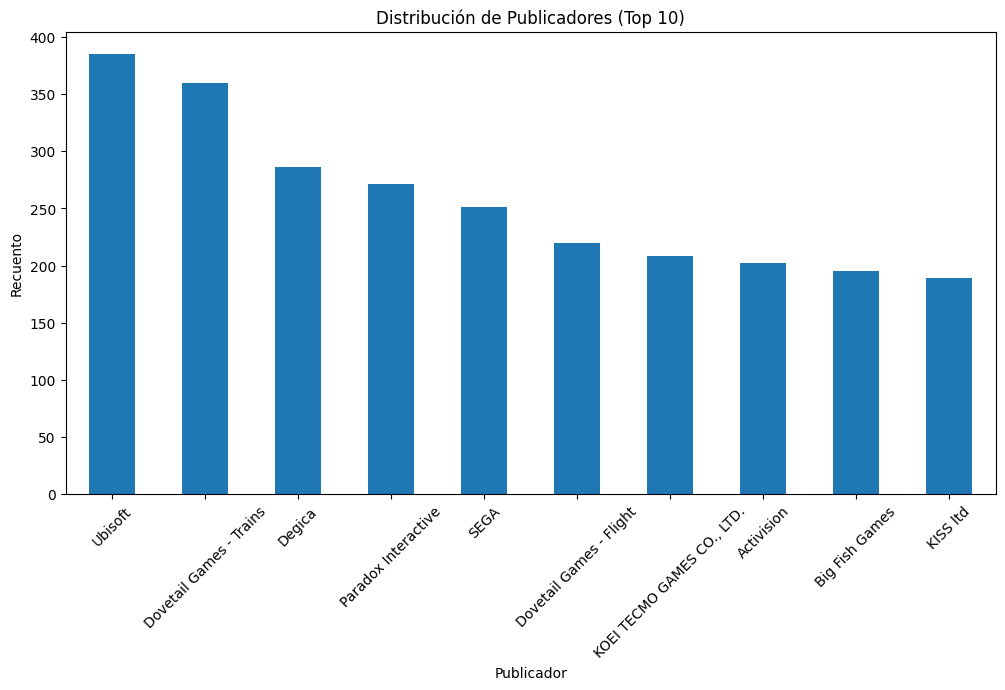

In [130]:

plt.figure(figsize=(12, 6))
df_games_full['publisher'].value_counts().head(10).plot(kind='bar')
plt.title('Distribución de Publicadores (Top 10)')
plt.xlabel('Publicador')
plt.ylabel('Recuento')
plt.xticks(rotation=45)
plt.show()

- Grafico 2: Distribución de Géneros (Genres)

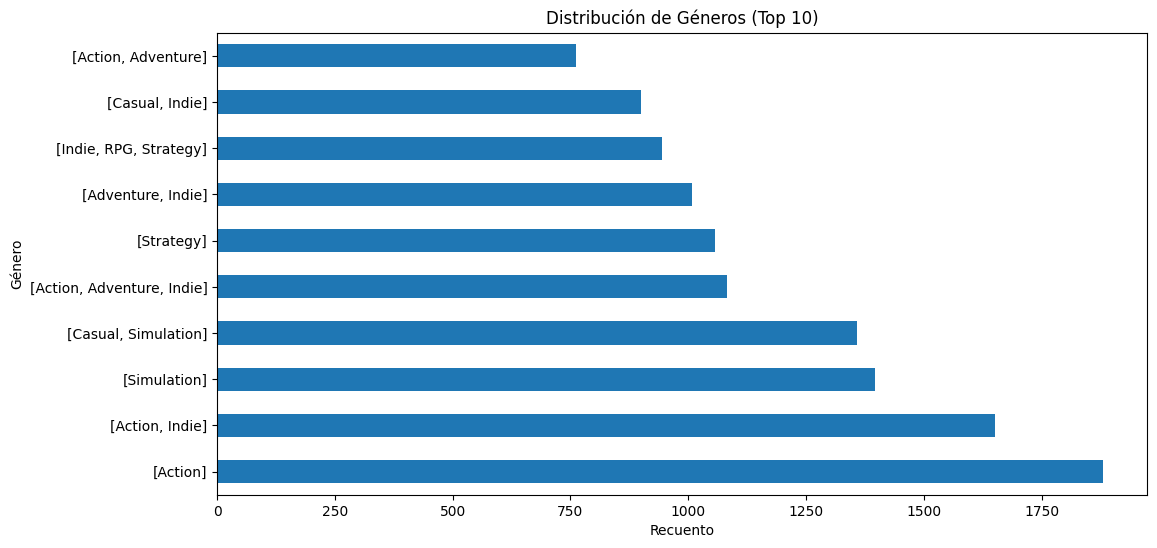

In [104]:
plt.figure(figsize=(12, 6))
df_games_full['genres'].value_counts().head(10).plot(kind='barh')
plt.title('Distribución de Géneros (Top 10)')
plt.xlabel('Recuento')
plt.ylabel('Género')
plt.show()

- Grafico 3: Distribución de Fechas de Lanzamiento (Release Date)

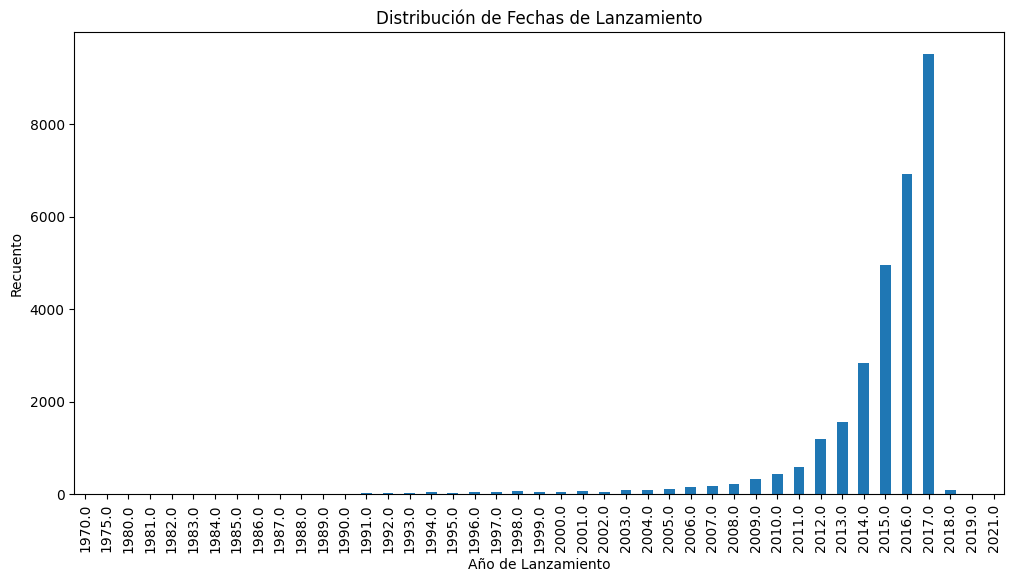

In [119]:
plt.figure(figsize=(12, 6))
df_games_full['release_date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Fechas de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Recuento')
plt.show()

Podemos observar un exponencial crecimiento de la plataforma en el año 2014, donde empiezan a aumentar considerablemente la publicacion de nuevos juegos. 

- Grafico 4: Proporción de Juegos con Acceso Temprano (Early Access)

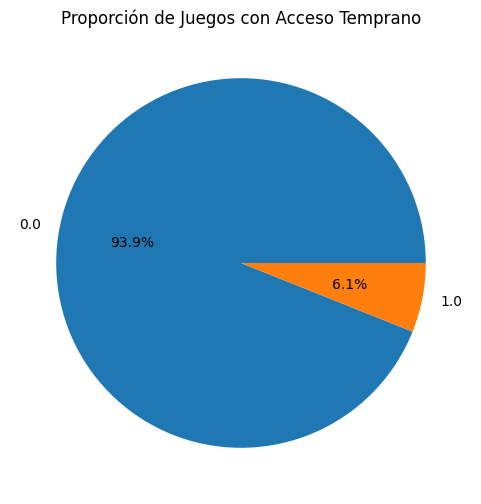

In [122]:
plt.figure(figsize=(6, 6))
df_games_full['early_access'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporción de Juegos con Acceso Temprano')
plt.ylabel('')
plt.show()

- Grafico 5: Distribución de Desarrolladores (Developer)

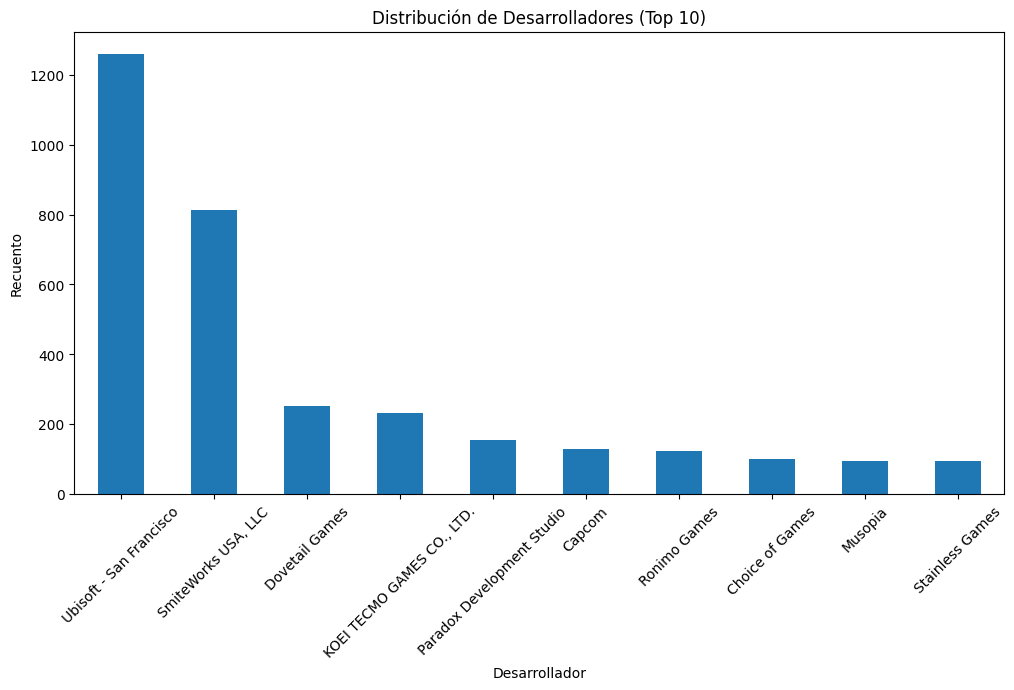

In [123]:
plt.figure(figsize=(12, 6))
df_games_full['developer'].value_counts().head(10).plot(kind='bar')
plt.title('Distribución de Desarrolladores (Top 10)')
plt.xlabel('Desarrollador')
plt.ylabel('Recuento')
plt.xticks(rotation=45)
plt.show()

# 6. **Modelamiento**
***

Para el modelamiento utilizaremos la siguiente librería, la cual contiene la herramienta 'Similitud de Coseno'. 

In [86]:
from sklearn.metrics.pairwise import cosine_similarity

Esto nos permite identificar en que medida se parece una variable con otra, tomando valores de similitud entre -1 y 1, siendo 1 una similud muy alta, cero muy baja y -1 totalmente opuesta. 

Para lograr esto, solo utilizaremos tres columnas del DataFrame. 

Estas serán: **'app_name', 'id'** y **'genre'**

In [87]:
df_modelo = df_games_full[['app_name', 'id','genres']].copy()

Buscamos valores nulos y si existen, los eliminamos. 

In [88]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   app_name  32133 non-null  object 
 1   id        32133 non-null  float64
 2   genres    28852 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1004.2+ KB


In [89]:
df_modelo.dropna(inplace=True)

In [90]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28850 entries, 88310 to 120443
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   app_name  28850 non-null  object 
 1   id        28850 non-null  float64
 2   genres    28850 non-null  object 
dtypes: float64(1), object(2)
memory usage: 901.6+ KB


Convertimos los ID a numeros enteros.

In [91]:
df_modelo['id'] = df_modelo['id'].astype(int)

Observamos el DataFrame

In [92]:
df_modelo.head()

,app_name,id,genres
88310,Lost Summoner Kitty,761140,"[Action, Casual, Indie, Simulation, Strategy]"
88311,Ironbound,643980,"[Free to Play, Indie, RPG, Strategy]"
88312,Real Pool 3D - Poolians,670290,"[Casual, Free to Play, Indie, Simulation, Sports]"
88313,弹炸人2222,767400,"[Action, Adventure, Casual]"
88315,Battle Royale Trainer,772540,"[Action, Adventure, Simulation]"


Lo que queremos ahora es crear una desanidar la lista en la columna 'genres' de modo de obtener para cada juego (app_name) una columna por genero. 

Esto lo generamos de la siguiente manera.

In [93]:
# Desanidamos la columna 'genres' y aplicar codificación one-hot
df_modelo_final = df_modelo.explode('genres')
df_modelo_final  = pd.get_dummies(df_modelo_final, columns=['genres'], prefix='genre')

# Reorganizamos el DataFrame
df_modelo_final = df_modelo_final.groupby(['app_name', 'id']).sum().reset_index()

In [94]:
df_modelo_final.head(5)

,app_name,id,genre_Accounting,genre_Action,genre_Adventure,genre_Animation &amp; Modeling,genre_Audio Production,genre_Casual,genre_Design &amp; Illustration,genre_Early Access,...,genre_Photo Editing,genre_RPG,genre_Racing,genre_Simulation,genre_Software Training,genre_Sports,genre_Strategy,genre_Utilities,genre_Video Production,genre_Web Publishing
0,! That Bastard Is Trying To Steal Our Gold !,449940,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"""Barely Attuned Magic Thingy"" Staff",308163,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"""Glow Ball"" - The billiard puzzle game",388390,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,"""Just Another Day"" - Seduce Me Otome CD",454790,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,"""Lethargic Sentience"" Wand",308164,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [95]:
df_modelo_final.shape

(28849, 24)

Una vez que tenemos el DataFrame armado de esta manera, estamos listos para buscar la Similitud de Cosenos.

In [96]:
similitudes = cosine_similarity(df_modelo_final.iloc[:,3:])

In [97]:
similitudes.shape

(28849, 28849)

Se observa que la cantidad de juegos que tenemos en nuetra base de datos es de 28.849.

Debido a que el peso de la matriz de similitud es muy grande y genera problemas en el rendimiento de la función, esta tomará como DataFrame de partida el generado anteriormente con el nombre de **df_modelo_final**. Una vez ingresado el DataFrame a la función, se calcula la matriz de similitud dentro de la misma para cada solicitud.

Además, siguiendo el mismo objetivo que es optimizar el desepeño de la función, lo que haremos será reducir el dataframe original disminuyendo la cantidad de juegos. Totamos esta decisión porque de no hacerlo, se presentan problemas cuando intentamos deployar la API en Render. 

Vamos a reducirlo a la mitad

In [98]:
num_filas = len(df_modelo_final)

df_modelo_final = df_modelo_final.iloc[:num_filas // 6]

In [99]:
df_modelo_final.shape

(4808, 24)

In [100]:
df_modelo_final.to_parquet('df_modelo_final.parquet')

Luego creamos la función de recomendación de juegos. 

In [101]:
def recomendacion_juego(id):
    
    id = int(id)
    # Filtrar el juego de entrada por su ID
    juego_seleccionado = df_modelo_final[df_modelo_final['id'] == id]
    
    if juego_seleccionado.empty:
        return "El juego con el ID especificado no existe en la base de datos."
    
    # Calcular la matriz de similitud coseno
    similitudes = cosine_similarity(df_modelo_final.iloc[:,3:])
    
    # Obtener las puntuaciones de similitud del juego de entrada con otros juegos
    similarity_scores = similitudes[df_modelo_final[df_modelo_final['id'] == id].index[0]]
    
    # Obtener los índices de los juegos más similares (excluyendo el juego de entrada)
    indices_juegos_similares = similarity_scores.argsort()[::-1][1:6]
    
    # Obtener los nombres de los juegos recomendados
    juegos_recomendados = df_modelo_final.iloc[indices_juegos_similares]['app_name']
    
    return juegos_recomendados

**Ejemplo:**

In [102]:
recomendacion_juego('449940')

629              Achievement Hunter: Begins
4519                         Combat Raccoon
1738                        Australian trip
1739    Australian trip - Full music tracks
4028               Chika Militant Cockroach
Name: app_name, dtype: object